<a href="https://colab.research.google.com/github/jazaineam1/BigData2023_2/blob/main/Cuadernos/7_Pyspark_y_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Spark intro 2***


## ***Universidad Externado de Colombia***

>## ***Maestría en Inteligencia de Negocios***
![Imágen1](https://www.uexternado.edu.co/wp-content/uploads/2020/07/logo-uec.png)

jazaineam@unal.edu.co


>## ***Big Data.***
>## ***Docente: Antonino Zainea Maya.***

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=03e4908576770fc57ae06ef109dfdf8b6cf107db7391892fd955b78423956009
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession
from pyspark.ml  import Pipeline
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

# **1. Recomendación de Películas con Pyspark** <a class="anchor" id="1"></a>


En primer lugar, debemos crear un contenedor de Spark llamando a SparkSession. Este paso es necesario antes de realizar cualquier acción.

In [ ]:
# Create SparkSession
spark = SparkSession.builder.appName('recommender_system').getOrCreate()

El método `Pyspark.toPandas()` nos permite devolver un SparkDataFrame como una tabla de Pandas para su visualización.

In [ ]:
!wget https://raw.githubusercontent.com/jazaineam1/BigData2023_2/main/Datos/movie_ratings_df.csv


--2023-10-19 21:46:12--  https://raw.githubusercontent.com/jazaineam1/BigData2023_2/main/Datos/movie_ratings_df.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3013032 (2.9M) [text/plain]
Saving to: ‘movie_ratings_df.csv’

movie_ratings_df.cs 100%[===================>]   2.87M  16.4MB/s    in 0.2s    

2023-10-19 21:46:13 (16.4 MB/s) - ‘movie_ratings_df.csv’ saved [3013032/3013032]



In [ ]:
# load the dataset and create sprk dataframe
df=spark.read.csv('/content/movie_ratings_df.csv',inferSchema=True,header=True)
# Using limit(), or select() or show() to view the data. I often use limit()
# Using toPandas() method to return Pyspark DataFrame as Pandas table
df.limit(3).toPandas()

,userId,title,rating
0,196,Kolya (1996),3
1,63,Kolya (1996),3
2,226,Kolya (1996),5


Nuestra tarea consiste en predecir y devolver una lista de recomendaciones de películas para un usuario en particular.

Usamos el método `printSchema()` para obtener una vista rápida de los tipos de datos de las características en nuestros datos. Esto nos permite comprender la estructura de los datos y verificar cómo están organizadas las columnas en el conjunto de datos.

In [ ]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



Como se puede ver, la columna de título se almacena como tipo de datos "string" (cadena de texto). Para trabajar con la biblioteca PySpark MLlib, necesitamos convertir las variables categóricas, como los títulos de las películas, en valores numéricos. Esto es importante porque muchos algoritmos de aprendizaje automático en PySpark MLlib requieren que las características de entrada sean numéricas en lugar de cadenas de texto. Puedes realizar esta conversión utilizando técnicas como la codificación de etiquetas (label encoding) o la codificación one-hot (one-hot encoding), dependiendo de la naturaleza de tus datos y de cómo planeas utilizarlos en tu modelo de recomendación de películas.

In [ ]:
from pyspark.ml.feature import StringIndexer, IndexToString
stringIndexer = StringIndexer(inputCol='title', outputCol='title_new')
# Applying stringindexer object on dataframe movie title column
model = stringIndexer.fit(df)
#creating new dataframe with transformed values
indexed = model.transform(df)
#validate the numerical title values
indexed.limit(5).toPandas()

,userId,title,rating,title_new
0,196,Kolya (1996),3,287.0
1,63,Kolya (1996),3,287.0
2,226,Kolya (1996),5,287.0
3,154,Kolya (1996),3,287.0
4,306,Kolya (1996),5,287.0


Estamos utilizando el algoritmo Alternating Least Squares (ALS) en la biblioteca PySpark ML para recomendaciones. Puedes obtener más información sobre este algoritmo y su implementación en PySpark visitando la página de documentación oficial en el siguiente enlace: [Collaborative Filtering in Apache Spark](https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html). Esta documentación proporciona detalles sobre cómo utilizar ALS para crear sistemas de recomendación en PySpark, así como ejemplos de código y pautas para su implementación.

In [ ]:
# split the data into training and test datatset
train, test = indexed.randomSplit([0.75,0.25])
from pyspark.ml.recommendation import ALS

#Training the recommender model using train datatset
rec=ALS( maxIter=10
        ,regParam=0.01
        ,userCol='userId'
        ,itemCol='title_new'
        ,ratingCol='rating'
        ,nonnegative=True
        ,coldStartStrategy="drop")

#fit the model on train set
rec_model=rec.fit(train)

#making predictions on test set
predicted_ratings=rec_model.transform(test)
predicted_ratings.limit(5).toPandas()

,userId,title,rating,title_new,prediction
0,148,Brazil (1985),4,109.0,4.413617
1,148,Dr. Strangelove or: How I Learned to Stop Worr...,5,123.0,3.656707
2,148,Fantasia (1940),5,153.0,4.072238
3,148,Four Weddings and a Funeral (1994),5,66.0,2.927681
4,148,Gone with the Wind (1939),5,162.0,4.332386


Evaluamos el entrenamiento

In [ ]:
# Importing Regression Evaluator to measure RMSE
from pyspark.ml.evaluation import RegressionEvaluator
# create Regressor evaluator object for measuring accuracy
evaluator=RegressionEvaluator(metricName='rmse',predictionCol='prediction',labelCol='rating')
# apply the RE on predictions dataframe to calculate RMSE
rmse=evaluator.evaluate(predicted_ratings)
# print RMSE error
print(rmse)

1.0298210209156309


Después de entrenar, ahora es el momento de recomendar las mejores películas que al usuario le podrían gustar.

In [ ]:
# First we need to create dataset of all distinct movies
unique_movies=indexed.select('title_new').distinct()

#create function to recommend top 'n' movies to any particular user
def top_movies(user_id,n):
    """
    This function returns the top 'n' movies that user has not seen yet but might like

    """
    #assigning alias name 'a' to unique movies df
    a = unique_movies.alias('a')

    #creating another dataframe which contains already watched movie by active user
    watched_movies=indexed.filter(indexed['userId'] == user_id).select('title_new')

    #assigning alias name 'b' to watched movies df
    b=watched_movies.alias('b')

    #joining both tables on left join
    total_movies = a.join(b, a.title_new == b.title_new,how='left')

    #selecting movies which active user is yet to rate or watch
    remaining_movies=total_movies.where(col("b.title_new").isNull()).select(a.title_new).distinct()


    #adding new column of user_Id of active useer to remaining movies df
    remaining_movies=remaining_movies.withColumn("userId",lit(int(user_id)))


    #making recommendations using ALS recommender model and selecting only top 'n' movies
    recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False).limit(n)


    #adding columns of movie titles in recommendations
    movie_title = IndexToString(inputCol="title_new", outputCol="title",labels=model.labels)
    final_recommendations=movie_title.transform(recommendations)

    #return the recommendations to active user
    return final_recommendations.show(n,False)

In [ ]:
# Test: recommend 5 movies for user of id=60
top_movies(60,5)

+---------+------+----------+---------------------------------------------------------------------------------+
|title_new|userId|prediction|title                                                                            |
+---------+------+----------+---------------------------------------------------------------------------------+
|1347.0   |60    |6.4751596 |Angel Baby (1995)                                                                |
|1143.0   |60    |5.837779  |Wonderland (1997)                                                                |
|926.0    |60    |5.7962646 |Ma vie en rose (My Life in Pink) (1997)                                          |
|1322.0   |60    |5.7282352 |Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)|
|1288.0   |60    |5.602875  |Whole Wide World, The (1996)                                                     |
+---------+------+----------+---------------------------------------------------------------------------

# **2. Modelo de Clasificación en PySpark** <a class="anchor" id="2"></a>



Estamos utilizando el conjunto de datos del Titanic para familiarizarnos con la manipulación de datos basada en DataFrames de PySpark.

## **2.1 EDA en Pyspark** <a class="anchor" id="2.1"></a>

In [ ]:
!wget https://raw.githubusercontent.com/jazaineam1/BigData2023_2/main/Datos/train.csv


--2023-10-19 21:54:31--  https://raw.githubusercontent.com/jazaineam1/BigData2023_2/main/Datos/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  59.76K  --.-KB/s    in 0.01s   

2023-10-19 21:54:31 (4.68 MB/s) - ‘train.csv’ saved [61194/61194]



In [ ]:
# Firstly we create sparkSession (like a container)
spark = SparkSession.builder.appName('Play with pyspark ML on titatic_dataset').getOrCreate()
# After creating spark, we use spark.read.csv to read dataset, like pandas.read_csv
df = spark.read.csv('train.csv',header = 'True',inferSchema='True')

In [ ]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [ ]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



Para la visualización, antes de utilizar bibliotecas de visualización (como Matplotlib, Seaborn, etc.), necesitamos convertir un SparkDataFrame en un PandasDataFrame.

<ipython-input-23-b730b0159392>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df['Age']);


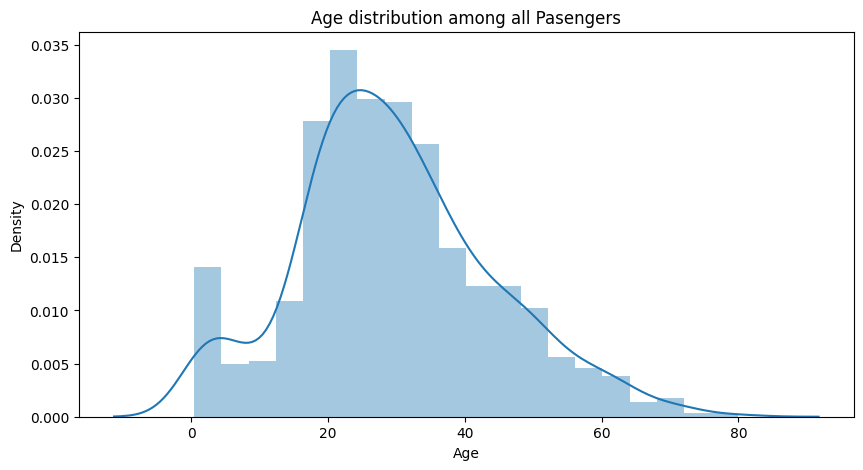

In [ ]:
pandas_df = df.toPandas()

plt.figure(figsize=(10,5))
plt.title('Age distribution among all Pasengers')
sns.distplot(pandas_df['Age']);

## Comprobación de valores nulos en PySpark:

- `isnan()` es una función del paquete `pyspark.sql.functions` y debemos especificar qué columna queremos utilizar como argumento de la función.
- `isNull()` pertenece al paquete `pyspark.sql.Column` y se utiliza para verificar el estado nulo de una columna en particular.

Para verificar valores nulos en PySpark, utilizamos ambas funciones mencionadas anteriormente.

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [ ]:
# Because Cabin column has a lot missing value ( > 50%) so we can remove it
df = df.drop("Cabin")

Para reemplazar estos valores NaN, podemos asignarles la edad promedio del conjunto de datos. Sin embargo, el problema es que había muchas personas de diferentes edades.

En la característica 'Name' (nombre), podemos ver que los nombres tienen una salutación como Sr. o Sra. Por lo tanto, podemos asignar los valores promedio de Sr. y Sra. a los grupos respectivos.

**Utilizando la expresión regular "[A-Za-z]+)." extraemos las iniciales del nombre. Esta expresión busca cadenas que se encuentran entre A-Z o a-z y están seguidas por un punto (.).**

In [ ]:
df = df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss


In [ ]:
# There are some misspelled Initials like Mlle or Mme that stand for Miss. we will replace them with Miss and same thing for other values.
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Checking the average age by Initials
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [ ]:
# Assigning missing values in age feature based on average age of Initials
df = df.withColumn("Age",when((df["Initial"] == "Miss")   & (df["Age"].isNull()), 22).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Other")  & (df["Age"].isNull()), 46).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Master") & (df["Age"].isNull()), 5).otherwise( df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mr")     & (df["Age"].isNull()), 33).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mrs")    & (df["Age"].isNull()), 36).otherwise(df["Age"]))

In [ ]:
# Embarked columns has two missing values, let check it
df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    NULL|    2|
|       C|  168|
|       S|  644|
+--------+-----+



Usamos `PysparkDataFrame.na.fill()` para llenar un valor en una columna específica.

In [ ]:
# As we can see, Majority Passengers boarded from "S". We can assign missing value with "S"
df = df.na.fill({"Embarked" : 'S'})
# Check again the missing value status
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



Después de manejar los valores faltantes, realizamos un poco de ingeniería de características.

En la ingeniería de características, podemos utilizar múltiples condiciones en PySpark con la sintaxis "When otherwise".

Para obtener más información sobre el uso de múltiples condiciones en PySpark, puedes visitar [este enlace](https://sparkbyexamples.com/spark/spark-case-when-otherwise-example/).

In [ ]:
df = df.withColumn("Family_Size",col('SibSp')+col('Parch')) # Create new column: Family_size
df = df.withColumn('Alone',lit(0))  # Create new column: Alone and assign 0 default value to Alone column
df = df.withColumn("Alone",when(df["Family_Size"] == 0, 1).otherwise(df["Alone"]))

# converting Sex, Embarked & Initial columns from string to number using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

In [ ]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0


In [ ]:
# Now we drop columns that not needed for modelling
df = df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

# Before modelling in Pyspark, we need to put all features to Vector using Pyspark VectorAssembler
feature = VectorAssembler(inputCols = df.columns[1:],outputCol="features")
feature_vector= feature.transform(df)
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


In [ ]:
# for data split in pyspark, we can use df.randomSplit()
(train_df, test_df) = feature_vector.randomSplit([0.8, 0.2],seed = 11)

In [ ]:
train_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)
 |-- features: vector (nullable = true)



# **2.2 Aprendizaje automático en PySpark** <a class="anchor" id="2.2"></a>



Solo para practicar, usaré algunos algoritmos de aprendizaje:

1. Regresión Logística
2. Clasificador de Bosques Aleatorios (RandomForestClassifier)
3. Clasificador de Árbol con Impulso Gradual (Gradient-boosted tree classifier)

In [ ]:
# Select features column for features training and 'Survived' as label to predict
titanic_df = feature_vector.select(['features','Survived'])
# Split the dataset to train_df and test_df
train_df,test_df = titanic_df.randomSplit([0.75,0.25])

## Regresión Logística

In [ ]:
# LOAD PYSPARK LIBRARIES
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc

# DEFINE ALGORITHM
lr = LogisticRegression(labelCol="Survived")

# DEFINE GRID PARAMETERS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# DEFINE CROSS VALIDATION WITH PARAMETERS
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))


Accuracy:  0.8277511961722488
Precision:  0.8267259056732741


### Evaluación de ROC

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])

## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is :  0.8604895773570473


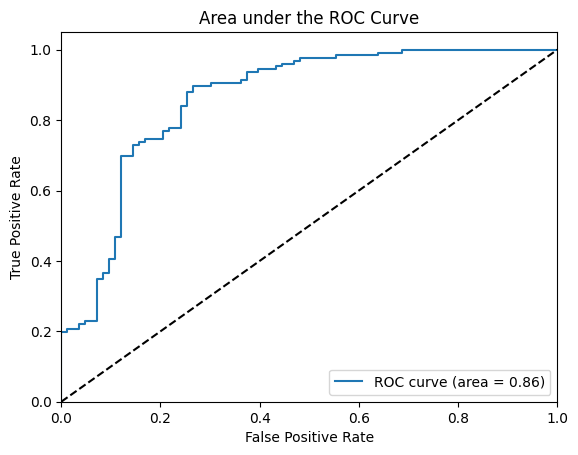

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [ ]:

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
rf = RandomForestClassifier(labelCol='Survived')
paramGrid = ParamGridBuilder()\
                                .addGrid(rf.maxDepth, [5, 10, 20]) \
                                .addGrid(rf.maxBins, [20, 32, 50]) \
                                .addGrid(rf.numTrees, [20, 40, 60 ]) \
                                .addGrid(rf.impurity, ["gini", "entropy"]) \
                                .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit( estimator=rf
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.8181818181818182
Precision:  0.8180704782051995


In [ ]:
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])

## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is :  0.8655574679671065


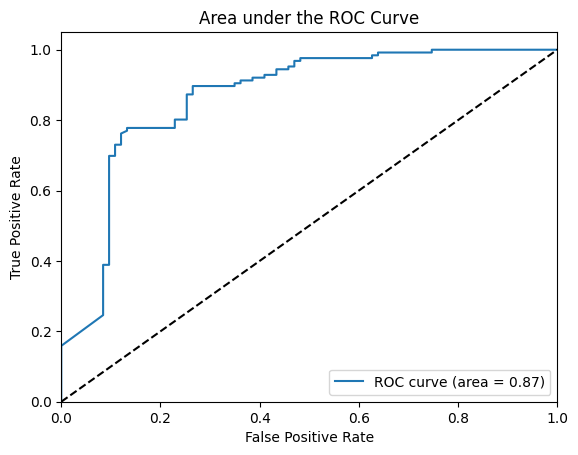

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Gradient Boosted Tree

In [ ]:

from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="Survived")
paramGrid = ParamGridBuilder()\
                            .addGrid(gbt.maxDepth, [5, 10, 20]) \
                            .addGrid(gbt.maxBins, [20, 32, 50]) \
                            .addGrid(gbt.maxIter, [10, 20, 30]) \
                            .addGrid(gbt.minInstancesPerNode, [1, 5, 10]) \
                            .build()

tvs = TrainValidationSplit(estimator=gbt
                           , estimatorParamMaps=paramGrid
                            ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                            ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.8038277511961722
Precision:  0.802491486702013


In [ ]:
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])

## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("The ROC score is: ", metrics.areaUnderROC)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is:  0.8717728055077447


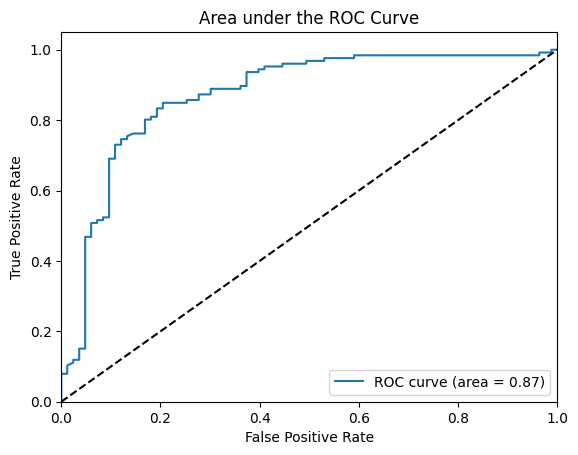

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

Taller 1

Con los datos disponibles en su proyecto, realice los siguientes pasos:

1. Cree un nuevo proyecto en Google Cloud Platform (GCP).
2. Establezca un nuevo "bucket" en GCP y almacene allí la información de su proyecto.

Si su objetivo es desarrollar un modelo de predicción de aprendizaje automático, siga estos pasos adicionales:

3.1. Construya una tabla en BigQuery utilizando los datos de su proyecto. Luego, genere un modelo en BigQuery y evalúe su rendimiento.

3.2. Configure un clúster en Dataproc y realice la limpieza de datos. Luego, utilice PySpark para crear el mismo modelo de predicción (consulte el siguiente video [enlace al video](https://www.youtube.com/watch?v=pBDY-Hbw30E)).

3.3. Realice pronósticos con el modelo y guárdelos en una nueva tabla de BigQuery.

Si, en cambio, está trabajando con un modelo preentrenado, siga estos pasos:

3.1. Cargue su modelo en Google Cloud Storage.
3.2. Configure un entorno de trabajo para ejecutar el modelo y cree un cuaderno (notebook) donde ejecute el modelo utilizando los datos almacenados en BigQuery.
3.3. Exporte los resultados a una nueva tabla en BigQuery.

La entrega de este taller debe realizarse en un documento que incluya capturas de pantalla de cada uno de los pasos mencionados anteriormente. La fecha límite para la entrega es el 2 de noviembre de 2023, antes de la medianoche. Asegúrese de seguir las instrucciones detalladas y de documentar adecuadamente cada paso del proceso. Si necesita más orientación o tiene alguna pregunta adicional, realizaremos algunas sesiones adicionales para solución de dudas los dias lunes y martes de 7:30 a 8:30.

